In [14]:
import torch
import utils
import matplotlib.pyplot as plt
import os
import numpy as np
import tqdm

from nnsight import LanguageModel

In [29]:
k=10
n_contexts=[1,10,40,70,100,130,160,190,220,250,280,310,340,370,400]
target_count=30
batch_size=16
data_seed=123
loop_seed=56234
model_name="meta-llama/Meta-Llama-3.1-70B"
save_path="./data/markov_mixture/llama/data_70B_v3.pt"

In [30]:
llama = LanguageModel(model_name, device_map="auto")

In [31]:
comma_token_id=llama.tokenizer.encode(",")[1]
relevant_token_ids=torch.tensor([comma_token_id]+[llama.tokenizer.encode(s)[1] for s in "0123456789"],dtype=torch.int64)
relevant_token_ids

tensor([11, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [32]:
Ts_collected=[]
current_Ts=torch.full((len(n_contexts),k,k),fill_value=torch.nan)
prefix="Continue the given sequence of digits between 0 and 9. The sequence comes from a Markov process, so it only depends on the last state. The sequence is as follows:\n"
token_ids_prefix=llama.tokenizer.encode(prefix)
i_sequence_start=len(token_ids_prefix)
np.random.seed(data_seed)
rss=np.random.randint(1000000,size=target_count)#this should be enough
generator=np.random.RandomState(loop_seed)
T_stars={}

i_done=0
while len(Ts_collected)<target_count:
    rs=rss[i_done]
    dataset_star=utils.get_markov_dataset_single(k=k,l=n_contexts[-1]+5,structured=False,random_state=rs)
    T_stars[i_done]=torch.tensor(dataset_star.T)
    np.random.seed(generator.randint(1000000))#generator set outside so each loop is different
    seqs=[]
    positions=[]
    token_ids=[]
    for _ in range(batch_size):
        seq=dataset_star.get_data()
        seqs.append(seq)
        data_str=",".join(seq.numpy().astype(str))
        data_str=prefix+data_str
        token_ids_=llama.tokenizer.encode(data_str,return_tensors="pt")
        token_ids.append(token_ids_)
    seqs=torch.stack(seqs,dim=0)
    print("Seqs shape:",seqs.shape)
    token_ids=torch.cat(token_ids,dim=0)
    print("Token ids shape:",token_ids.shape)
    
    with llama.trace(token_ids, remote=True) as runner:
        logits=llama.output.logits
        relevant_logits=logits[:,:,relevant_token_ids].save()
    print("Relevant logits shape:",relevant_logits.shape)
    
    positions=np.arange(i_sequence_start+1,token_ids.shape[1],2).tolist()#comma positions
    relevant_logits=relevant_logits[:,positions,:]
    comma_probs=torch.nn.functional.softmax(relevant_logits,dim=-1)[:,:,0]
    if torch.any(comma_probs>1e-2):
        print("Found a comma, skipping")
        continue
    probss=torch.nn.functional.softmax(relevant_logits[:,:,1:],dim=-1)
    print("Probss shape:",probss.shape)
        
    for i_n_context,n_context in enumerate(n_contexts):
        for seq,probs in zip(seqs,probss):
            last_state=seq[n_context-1]
            val=current_Ts[i_n_context,last_state,:]
            if torch.isnan(val[0]):
                current_Ts[i_n_context,last_state,:]=probs[n_context-1,:]
    #check if Ts are filled
    if torch.all(~torch.isnan(current_Ts)):
        print("Ts are filled, collecting")
        Ts_collected.append(current_Ts.clone())
        current_Ts[...]=torch.nan
        i_done+=1
    print(f"Collected {len(Ts_collected)} Tss")
Ts_collected=torch.stack(Ts_collected)
T_stars=torch.stack([T_stars[i] for i in range(target_count)],dim=0)
Ts_collected.shape,T_stars.shape

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:34:54,825 MainProcess nnsight_remote INFO     3837828e-b6a3-4840-b8c9-ff9d46606b49 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:34:54,871 MainProcess nnsight_remote INFO     3837828e-b6a3-4840-b8c9-ff9d46606b49 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:34:54,884 MainProcess nnsight_remote INFO     3837828e-b6a3-4840-b8c9-ff9d46606b49 - RUNNING: Your job has started running.
2024-09-14 17:35:01,856 MainProcess nnsight_remote INFO     3837828e-b6a3-4840-b8c9-ff9d46606b49 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 0 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:35:03,440 MainProcess nnsight_remote INFO     0749f24c-d9b9-4f3d-8732-f5792957ac8a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:35:03,501 MainProcess nnsight_remote INFO     0749f24c-d9b9-4f3d-8732-f5792957ac8a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:35:03,513 MainProcess nnsight_remote INFO     0749f24c-d9b9-4f3d-8732-f5792957ac8a - RUNNING: Your job has started running.
2024-09-14 17:35:10,453 MainProcess nnsight_remote INFO     0749f24c-d9b9-4f3d-8732-f5792957ac8a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 0 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:35:11,836 MainProcess nnsight_remote INFO     e4793755-d44d-48e1-83b9-12c50f422488 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:35:11,898 MainProcess nnsight_remote INFO     e4793755-d44d-48e1-83b9-12c50f422488 - RUNNING: Your job has started running.
2024-09-14 17:35:11,901 MainProcess nnsight_remote INFO     e4793755-d44d-48e1-83b9-12c50f422488 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:35:18,884 MainProcess nnsight_remote INFO     e4793755-d44d-48e1-83b9-12c50f422488 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 0 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:35:20,233 MainProcess nnsight_remote INFO     68f41f72-0148-47cd-bd59-a98c5d68a782 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:35:20,280 MainProcess nnsight_remote INFO     68f41f72-0148-47cd-bd59-a98c5d68a782 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:35:20,291 MainProcess nnsight_remote INFO     68f41f72-0148-47cd-bd59-a98c5d68a782 - RUNNING: Your job has started running.
2024-09-14 17:35:27,230 MainProcess nnsight_remote INFO     68f41f72-0148-47cd-bd59-a98c5d68a782 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 0 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:35:28,713 MainProcess nnsight_remote INFO     1c45f75b-ece2-4a1b-aec8-4fcfb842e154 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:35:28,766 MainProcess nnsight_remote INFO     1c45f75b-ece2-4a1b-aec8-4fcfb842e154 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:35:28,772 MainProcess nnsight_remote INFO     1c45f75b-ece2-4a1b-aec8-4fcfb842e154 - RUNNING: Your job has started running.
2024-09-14 17:35:35,697 MainProcess nnsight_remote INFO     1c45f75b-ece2-4a1b-aec8-4fcfb842e154 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:35:36,995 MainProcess nnsight_remote INFO     0696d695-0f7a-4022-8d87-7f3ec816cfee - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:35:37,041 MainProcess nnsight_remote INFO     0696d695-0f7a-4022-8d87-7f3ec816cfee - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:35:37,048 MainProcess nnsight_remote INFO     0696d695-0f7a-4022-8d87-7f3ec816cfee - RUNNING: Your job has started running.
2024-09-14 17:35:44,023 MainProcess nnsight_remote INFO     0696d695-0f7a-4022-8d87-7f3ec816cfee - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:35:45,341 MainProcess nnsight_remote INFO     2e7fbd69-5721-4abf-a5fa-672a78b7b984 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:35:45,409 MainProcess nnsight_remote INFO     2e7fbd69-5721-4abf-a5fa-672a78b7b984 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:35:45,438 MainProcess nnsight_remote INFO     2e7fbd69-5721-4abf-a5fa-672a78b7b984 - RUNNING: Your job has started running.
2024-09-14 17:35:52,354 MainProcess nnsight_remote INFO     2e7fbd69-5721-4abf-a5fa-672a78b7b984 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:35:53,737 MainProcess nnsight_remote INFO     5281e09b-0d37-4e0e-a2e5-699351354320 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:35:53,797 MainProcess nnsight_remote INFO     5281e09b-0d37-4e0e-a2e5-699351354320 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:35:53,804 MainProcess nnsight_remote INFO     5281e09b-0d37-4e0e-a2e5-699351354320 - RUNNING: Your job has started running.
2024-09-14 17:36:00,746 MainProcess nnsight_remote INFO     5281e09b-0d37-4e0e-a2e5-699351354320 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:36:01,923 MainProcess nnsight_remote INFO     fb0f18ac-59ad-48bf-ae99-e24edadfad7b - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:36:01,963 MainProcess nnsight_remote INFO     fb0f18ac-59ad-48bf-ae99-e24edadfad7b - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:36:01,971 MainProcess nnsight_remote INFO     fb0f18ac-59ad-48bf-ae99-e24edadfad7b - RUNNING: Your job has started running.
2024-09-14 17:36:08,930 MainProcess nnsight_remote INFO     fb0f18ac-59ad-48bf-ae99-e24edadfad7b - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:36:10,264 MainProcess nnsight_remote INFO     24588368-3aa0-4dc6-a159-34b9dce22f28 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:36:10,308 MainProcess nnsight_remote INFO     24588368-3aa0-4dc6-a159-34b9dce22f28 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:36:10,320 MainProcess nnsight_remote INFO     24588368-3aa0-4dc6-a159-34b9dce22f28 - RUNNING: Your job has started running.
2024-09-14 17:36:17,331 MainProcess nnsight_remote INFO     24588368-3aa0-4dc6-a159-34b9dce22f28 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:36:18,557 MainProcess nnsight_remote INFO     7b58ec3d-ffe2-4b23-b34f-34fdfecb2c97 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:36:18,602 MainProcess nnsight_remote INFO     7b58ec3d-ffe2-4b23-b34f-34fdfecb2c97 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:36:18,610 MainProcess nnsight_remote INFO     7b58ec3d-ffe2-4b23-b34f-34fdfecb2c97 - RUNNING: Your job has started running.
2024-09-14 17:36:25,607 MainProcess nnsight_remote INFO     7b58ec3d-ffe2-4b23-b34f-34fdfecb2c97 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:36:27,373 MainProcess nnsight_remote INFO     3a4ca27e-569f-4999-83e2-c622e0de859e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:36:27,409 MainProcess nnsight_remote INFO     3a4ca27e-569f-4999-83e2-c622e0de859e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:36:27,420 MainProcess nnsight_remote INFO     3a4ca27e-569f-4999-83e2-c622e0de859e - RUNNING: Your job has started running.
2024-09-14 17:36:34,411 MainProcess nnsight_remote INFO     3a4ca27e-569f-4999-83e2-c622e0de859e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 1 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:36:35,961 MainProcess nnsight_remote INFO     479e0a22-4f77-40f8-90f3-e07140d0b85d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:36:36,000 MainProcess nnsight_remote INFO     479e0a22-4f77-40f8-90f3-e07140d0b85d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:36:36,013 MainProcess nnsight_remote INFO     479e0a22-4f77-40f8-90f3-e07140d0b85d - RUNNING: Your job has started running.
2024-09-14 17:36:42,982 MainProcess nnsight_remote INFO     479e0a22-4f77-40f8-90f3-e07140d0b85d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 2 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:36:44,407 MainProcess nnsight_remote INFO     0881ad3f-3056-4214-8421-436be080772c - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:36:44,441 MainProcess nnsight_remote INFO     0881ad3f-3056-4214-8421-436be080772c - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:36:44,445 MainProcess nnsight_remote INFO     0881ad3f-3056-4214-8421-436be080772c - RUNNING: Your job has started running.
2024-09-14 17:36:51,404 MainProcess nnsight_remote INFO     0881ad3f-3056-4214-8421-436be080772c - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 2 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:36:52,446 MainProcess nnsight_remote INFO     72f643c8-fb0a-49a6-91e1-a86e7125dc25 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:36:52,493 MainProcess nnsight_remote INFO     72f643c8-fb0a-49a6-91e1-a86e7125dc25 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:36:52,508 MainProcess nnsight_remote INFO     72f643c8-fb0a-49a6-91e1-a86e7125dc25 - RUNNING: Your job has started running.
2024-09-14 17:36:59,494 MainProcess nnsight_remote INFO     72f643c8-fb0a-49a6-91e1-a86e7125dc25 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 2 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:37:00,804 MainProcess nnsight_remote INFO     68353315-3185-44f0-a4b7-102e703ec641 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:37:00,869 MainProcess nnsight_remote INFO     68353315-3185-44f0-a4b7-102e703ec641 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:37:00,876 MainProcess nnsight_remote INFO     68353315-3185-44f0-a4b7-102e703ec641 - RUNNING: Your job has started running.
2024-09-14 17:37:07,829 MainProcess nnsight_remote INFO     68353315-3185-44f0-a4b7-102e703ec641 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 2 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:37:09,396 MainProcess nnsight_remote INFO     40de998a-e985-406f-be5a-b459e1bd7238 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:37:09,423 MainProcess nnsight_remote INFO     40de998a-e985-406f-be5a-b459e1bd7238 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:37:09,631 MainProcess nnsight_remote INFO     40de998a-e985-406f-be5a-b459e1bd7238 - RUNNING: Your job has started running.
2024-09-14 17:37:16,643 MainProcess nnsight_remote INFO     40de998a-e985-406f-be5a-b459e1bd7238 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 2 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:37:18,119 MainProcess nnsight_remote INFO     37426e0f-0e9a-487f-9051-e71025ad160d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:37:18,159 MainProcess nnsight_remote INFO     37426e0f-0e9a-487f-9051-e71025ad160d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:37:18,173 MainProcess nnsight_remote INFO     37426e0f-0e9a-487f-9051-e71025ad160d - RUNNING: Your job has started running.
2024-09-14 17:37:25,134 MainProcess nnsight_remote INFO     37426e0f-0e9a-487f-9051-e71025ad160d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 3 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:37:26,344 MainProcess nnsight_remote INFO     87e5a4ad-199b-49e0-9397-691125e9e7ae - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:37:26,373 MainProcess nnsight_remote INFO     87e5a4ad-199b-49e0-9397-691125e9e7ae - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:37:26,399 MainProcess nnsight_remote INFO     87e5a4ad-199b-49e0-9397-691125e9e7ae - RUNNING: Your job has started running.
2024-09-14 17:37:33,354 MainProcess nnsight_remote INFO     87e5a4ad-199b-49e0-9397-691125e9e7ae - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 3 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:37:34,725 MainProcess nnsight_remote INFO     aa925e6d-6337-4055-a5a0-ee9a566dafd2 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:37:34,795 MainProcess nnsight_remote INFO     aa925e6d-6337-4055-a5a0-ee9a566dafd2 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:37:34,807 MainProcess nnsight_remote INFO     aa925e6d-6337-4055-a5a0-ee9a566dafd2 - RUNNING: Your job has started running.
2024-09-14 17:37:41,735 MainProcess nnsight_remote INFO     aa925e6d-6337-4055-a5a0-ee9a566dafd2 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 3 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:37:42,919 MainProcess nnsight_remote INFO     e87d274f-8b21-4651-9131-3b9e24c53bf4 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:37:42,957 MainProcess nnsight_remote INFO     e87d274f-8b21-4651-9131-3b9e24c53bf4 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:37:42,972 MainProcess nnsight_remote INFO     e87d274f-8b21-4651-9131-3b9e24c53bf4 - RUNNING: Your job has started running.
2024-09-14 17:37:49,945 MainProcess nnsight_remote INFO     e87d274f-8b21-4651-9131-3b9e24c53bf4 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 3 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:37:51,385 MainProcess nnsight_remote INFO     8538aeef-1f79-482a-b645-91120d72b139 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:37:51,423 MainProcess nnsight_remote INFO     8538aeef-1f79-482a-b645-91120d72b139 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:37:51,436 MainProcess nnsight_remote INFO     8538aeef-1f79-482a-b645-91120d72b139 - RUNNING: Your job has started running.
2024-09-14 17:37:58,413 MainProcess nnsight_remote INFO     8538aeef-1f79-482a-b645-91120d72b139 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:37:59,665 MainProcess nnsight_remote INFO     0e9927ae-0c82-4e80-bcea-a0d7aa220484 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:37:59,703 MainProcess nnsight_remote INFO     0e9927ae-0c82-4e80-bcea-a0d7aa220484 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:37:59,947 MainProcess nnsight_remote INFO     0e9927ae-0c82-4e80-bcea-a0d7aa220484 - RUNNING: Your job has started running.
2024-09-14 17:38:06,944 MainProcess nnsight_remote INFO     0e9927ae-0c82-4e80-bcea-a0d7aa220484 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:38:08,610 MainProcess nnsight_remote INFO     0ac395b0-a3b7-4437-8cfb-c983f140f4c5 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:38:08,658 MainProcess nnsight_remote INFO     0ac395b0-a3b7-4437-8cfb-c983f140f4c5 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:38:08,677 MainProcess nnsight_remote INFO     0ac395b0-a3b7-4437-8cfb-c983f140f4c5 - RUNNING: Your job has started running.
2024-09-14 17:38:15,668 MainProcess nnsight_remote INFO     0ac395b0-a3b7-4437-8cfb-c983f140f4c5 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:38:16,931 MainProcess nnsight_remote INFO     742e32f7-31e3-42a4-953a-a5a152276b8e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:38:16,963 MainProcess nnsight_remote INFO     742e32f7-31e3-42a4-953a-a5a152276b8e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:38:16,979 MainProcess nnsight_remote INFO     742e32f7-31e3-42a4-953a-a5a152276b8e - RUNNING: Your job has started running.
2024-09-14 17:38:23,998 MainProcess nnsight_remote INFO     742e32f7-31e3-42a4-953a-a5a152276b8e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:38:25,253 MainProcess nnsight_remote INFO     a504cb09-abc0-40a5-a1a9-376de3b19cfc - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:38:25,332 MainProcess nnsight_remote INFO     a504cb09-abc0-40a5-a1a9-376de3b19cfc - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:38:25,347 MainProcess nnsight_remote INFO     a504cb09-abc0-40a5-a1a9-376de3b19cfc - RUNNING: Your job has started running.
2024-09-14 17:38:32,356 MainProcess nnsight_remote INFO     a504cb09-abc0-40a5-a1a9-376de3b19cfc - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:38:33,603 MainProcess nnsight_remote INFO     2448cfe1-dd59-411d-8ebf-1328e3ecb357 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:38:33,656 MainProcess nnsight_remote INFO     2448cfe1-dd59-411d-8ebf-1328e3ecb357 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:38:33,932 MainProcess nnsight_remote INFO     2448cfe1-dd59-411d-8ebf-1328e3ecb357 - RUNNING: Your job has started running.
2024-09-14 17:38:40,924 MainProcess nnsight_remote INFO     2448cfe1-dd59-411d-8ebf-1328e3ecb357 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 4 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:38:42,004 MainProcess nnsight_remote INFO     3a2abcb7-10ea-4138-b9a3-844e4845f8c2 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:38:42,055 MainProcess nnsight_remote INFO     3a2abcb7-10ea-4138-b9a3-844e4845f8c2 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:38:42,069 MainProcess nnsight_remote INFO     3a2abcb7-10ea-4138-b9a3-844e4845f8c2 - RUNNING: Your job has started running.
2024-09-14 17:38:49,058 MainProcess nnsight_remote INFO     3a2abcb7-10ea-4138-b9a3-844e4845f8c2 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:38:50,380 MainProcess nnsight_remote INFO     adc8bbc5-7879-49a7-b2b8-b5208ceb14b7 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:38:50,424 MainProcess nnsight_remote INFO     adc8bbc5-7879-49a7-b2b8-b5208ceb14b7 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:38:50,440 MainProcess nnsight_remote INFO     adc8bbc5-7879-49a7-b2b8-b5208ceb14b7 - RUNNING: Your job has started running.
2024-09-14 17:38:57,455 MainProcess nnsight_remote INFO     adc8bbc5-7879-49a7-b2b8-b5208ceb14b7 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:38:59,197 MainProcess nnsight_remote INFO     e92cf606-3100-429f-8044-d7f2a87a20cc - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:38:59,259 MainProcess nnsight_remote INFO     e92cf606-3100-429f-8044-d7f2a87a20cc - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:38:59,269 MainProcess nnsight_remote INFO     e92cf606-3100-429f-8044-d7f2a87a20cc - RUNNING: Your job has started running.
2024-09-14 17:39:06,268 MainProcess nnsight_remote INFO     e92cf606-3100-429f-8044-d7f2a87a20cc - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:39:07,592 MainProcess nnsight_remote INFO     41062ccc-7a2a-4886-93ac-009a09195cca - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:39:07,642 MainProcess nnsight_remote INFO     41062ccc-7a2a-4886-93ac-009a09195cca - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:39:07,665 MainProcess nnsight_remote INFO     41062ccc-7a2a-4886-93ac-009a09195cca - RUNNING: Your job has started running.
2024-09-14 17:39:14,678 MainProcess nnsight_remote INFO     41062ccc-7a2a-4886-93ac-009a09195cca - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:39:15,756 MainProcess nnsight_remote INFO     fe120a3b-0374-4e8c-b2bb-18302824a737 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:39:15,816 MainProcess nnsight_remote INFO     fe120a3b-0374-4e8c-b2bb-18302824a737 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:39:15,830 MainProcess nnsight_remote INFO     fe120a3b-0374-4e8c-b2bb-18302824a737 - RUNNING: Your job has started running.
2024-09-14 17:39:22,841 MainProcess nnsight_remote INFO     fe120a3b-0374-4e8c-b2bb-18302824a737 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:39:24,194 MainProcess nnsight_remote INFO     9afda0b4-f3f2-4453-acbf-2e63d7cfc409 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:39:24,224 MainProcess nnsight_remote INFO     9afda0b4-f3f2-4453-acbf-2e63d7cfc409 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:39:24,236 MainProcess nnsight_remote INFO     9afda0b4-f3f2-4453-acbf-2e63d7cfc409 - RUNNING: Your job has started running.
2024-09-14 17:39:31,239 MainProcess nnsight_remote INFO     9afda0b4-f3f2-4453-acbf-2e63d7cfc409 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:39:32,521 MainProcess nnsight_remote INFO     4d421c6f-e406-48e6-8788-829710d39e2d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:39:32,596 MainProcess nnsight_remote INFO     4d421c6f-e406-48e6-8788-829710d39e2d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:39:32,606 MainProcess nnsight_remote INFO     4d421c6f-e406-48e6-8788-829710d39e2d - RUNNING: Your job has started running.
2024-09-14 17:39:39,663 MainProcess nnsight_remote INFO     4d421c6f-e406-48e6-8788-829710d39e2d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 5 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:39:41,271 MainProcess nnsight_remote INFO     a626ead6-f432-4360-9430-89e02bf95196 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:39:41,309 MainProcess nnsight_remote INFO     a626ead6-f432-4360-9430-89e02bf95196 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:39:41,323 MainProcess nnsight_remote INFO     a626ead6-f432-4360-9430-89e02bf95196 - RUNNING: Your job has started running.
2024-09-14 17:39:48,351 MainProcess nnsight_remote INFO     a626ead6-f432-4360-9430-89e02bf95196 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 6 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:39:50,599 MainProcess nnsight_remote INFO     ce7a5b73-afdc-451c-b8c0-9beb41690ee9 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:39:50,667 MainProcess nnsight_remote INFO     ce7a5b73-afdc-451c-b8c0-9beb41690ee9 - RUNNING: Your job has started running.
2024-09-14 17:39:50,668 MainProcess nnsight_remote INFO     ce7a5b73-afdc-451c-b8c0-9beb41690ee9 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:39:57,656 MainProcess nnsight_remote INFO     ce7a5b73-afdc-451c-b8c0-9beb41690ee9 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 6 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:39:58,984 MainProcess nnsight_remote INFO     ce2a1660-e53c-48cc-a2f3-e1395131870d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:39:59,013 MainProcess nnsight_remote INFO     ce2a1660-e53c-48cc-a2f3-e1395131870d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:39:59,028 MainProcess nnsight_remote INFO     ce2a1660-e53c-48cc-a2f3-e1395131870d - RUNNING: Your job has started running.
2024-09-14 17:40:06,066 MainProcess nnsight_remote INFO     ce2a1660-e53c-48cc-a2f3-e1395131870d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 6 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:40:07,481 MainProcess nnsight_remote INFO     23879c7b-c623-4cf6-b95e-6bb849bb8850 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:40:07,513 MainProcess nnsight_remote INFO     23879c7b-c623-4cf6-b95e-6bb849bb8850 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:40:07,542 MainProcess nnsight_remote INFO     23879c7b-c623-4cf6-b95e-6bb849bb8850 - RUNNING: Your job has started running.
2024-09-14 17:40:14,574 MainProcess nnsight_remote INFO     23879c7b-c623-4cf6-b95e-6bb849bb8850 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 6 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:40:16,026 MainProcess nnsight_remote INFO     5f4c9b7a-1a63-4a45-b838-68d2d308ef05 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:40:16,115 MainProcess nnsight_remote INFO     5f4c9b7a-1a63-4a45-b838-68d2d308ef05 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:40:16,128 MainProcess nnsight_remote INFO     5f4c9b7a-1a63-4a45-b838-68d2d308ef05 - RUNNING: Your job has started running.
2024-09-14 17:40:23,154 MainProcess nnsight_remote INFO     5f4c9b7a-1a63-4a45-b838-68d2d308ef05 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 6 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:40:24,489 MainProcess nnsight_remote INFO     cafcce68-4a52-4bad-b348-e99aa335dd67 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:40:24,530 MainProcess nnsight_remote INFO     cafcce68-4a52-4bad-b348-e99aa335dd67 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:40:24,538 MainProcess nnsight_remote INFO     cafcce68-4a52-4bad-b348-e99aa335dd67 - RUNNING: Your job has started running.
2024-09-14 17:40:31,553 MainProcess nnsight_remote INFO     cafcce68-4a52-4bad-b348-e99aa335dd67 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 7 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:40:33,250 MainProcess nnsight_remote INFO     4e7b8d22-b1f4-4b3f-9a59-48bcf9b5b562 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:40:33,290 MainProcess nnsight_remote INFO     4e7b8d22-b1f4-4b3f-9a59-48bcf9b5b562 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:40:33,297 MainProcess nnsight_remote INFO     4e7b8d22-b1f4-4b3f-9a59-48bcf9b5b562 - RUNNING: Your job has started running.
2024-09-14 17:40:40,317 MainProcess nnsight_remote INFO     4e7b8d22-b1f4-4b3f-9a59-48bcf9b5b562 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 7 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:40:41,422 MainProcess nnsight_remote INFO     b6dc9411-2ee0-42fe-97cc-f18cd1d79e81 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:40:41,487 MainProcess nnsight_remote INFO     b6dc9411-2ee0-42fe-97cc-f18cd1d79e81 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:40:41,507 MainProcess nnsight_remote INFO     b6dc9411-2ee0-42fe-97cc-f18cd1d79e81 - RUNNING: Your job has started running.
2024-09-14 17:40:48,517 MainProcess nnsight_remote INFO     b6dc9411-2ee0-42fe-97cc-f18cd1d79e81 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 7 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:40:49,810 MainProcess nnsight_remote INFO     5d6ac500-f57a-4156-947c-bac77379f98a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:40:49,842 MainProcess nnsight_remote INFO     5d6ac500-f57a-4156-947c-bac77379f98a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:40:49,859 MainProcess nnsight_remote INFO     5d6ac500-f57a-4156-947c-bac77379f98a - RUNNING: Your job has started running.
2024-09-14 17:40:56,885 MainProcess nnsight_remote INFO     5d6ac500-f57a-4156-947c-bac77379f98a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 7 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:40:58,206 MainProcess nnsight_remote INFO     0407c868-3537-40f5-b410-c41274fbb9d7 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:40:58,262 MainProcess nnsight_remote INFO     0407c868-3537-40f5-b410-c41274fbb9d7 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:40:58,272 MainProcess nnsight_remote INFO     0407c868-3537-40f5-b410-c41274fbb9d7 - RUNNING: Your job has started running.
2024-09-14 17:41:05,280 MainProcess nnsight_remote INFO     0407c868-3537-40f5-b410-c41274fbb9d7 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:41:06,552 MainProcess nnsight_remote INFO     738dc106-3ec1-438d-b0fb-ca26b2c4792f - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:41:06,598 MainProcess nnsight_remote INFO     738dc106-3ec1-438d-b0fb-ca26b2c4792f - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:41:06,611 MainProcess nnsight_remote INFO     738dc106-3ec1-438d-b0fb-ca26b2c4792f - RUNNING: Your job has started running.
2024-09-14 17:41:13,581 MainProcess nnsight_remote INFO     738dc106-3ec1-438d-b0fb-ca26b2c4792f - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:41:14,835 MainProcess nnsight_remote INFO     ce6b52e4-56f3-462a-a939-cf02b266c586 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:41:14,871 MainProcess nnsight_remote INFO     ce6b52e4-56f3-462a-a939-cf02b266c586 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:41:14,878 MainProcess nnsight_remote INFO     ce6b52e4-56f3-462a-a939-cf02b266c586 - RUNNING: Your job has started running.
2024-09-14 17:41:21,878 MainProcess nnsight_remote INFO     ce6b52e4-56f3-462a-a939-cf02b266c586 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:41:23,229 MainProcess nnsight_remote INFO     714f0667-dbc6-4daf-9364-f052a918d517 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:41:23,269 MainProcess nnsight_remote INFO     714f0667-dbc6-4daf-9364-f052a918d517 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:41:23,278 MainProcess nnsight_remote INFO     714f0667-dbc6-4daf-9364-f052a918d517 - RUNNING: Your job has started running.
2024-09-14 17:41:30,299 MainProcess nnsight_remote INFO     714f0667-dbc6-4daf-9364-f052a918d517 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:41:31,621 MainProcess nnsight_remote INFO     dbf435ea-0b05-46c4-a366-01d3d913191e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:41:31,668 MainProcess nnsight_remote INFO     dbf435ea-0b05-46c4-a366-01d3d913191e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:41:31,684 MainProcess nnsight_remote INFO     dbf435ea-0b05-46c4-a366-01d3d913191e - RUNNING: Your job has started running.
2024-09-14 17:41:38,700 MainProcess nnsight_remote INFO     dbf435ea-0b05-46c4-a366-01d3d913191e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:41:40,259 MainProcess nnsight_remote INFO     ea065322-86ad-4a4d-a3e9-980f347b612f - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:41:40,335 MainProcess nnsight_remote INFO     ea065322-86ad-4a4d-a3e9-980f347b612f - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:41:40,351 MainProcess nnsight_remote INFO     ea065322-86ad-4a4d-a3e9-980f347b612f - RUNNING: Your job has started running.
2024-09-14 17:41:47,384 MainProcess nnsight_remote INFO     ea065322-86ad-4a4d-a3e9-980f347b612f - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 8 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:41:48,691 MainProcess nnsight_remote INFO     939c9409-b289-4058-a8b6-e95f90948a10 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:41:48,731 MainProcess nnsight_remote INFO     939c9409-b289-4058-a8b6-e95f90948a10 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:41:48,739 MainProcess nnsight_remote INFO     939c9409-b289-4058-a8b6-e95f90948a10 - RUNNING: Your job has started running.
2024-09-14 17:41:55,757 MainProcess nnsight_remote INFO     939c9409-b289-4058-a8b6-e95f90948a10 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 9 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:41:56,955 MainProcess nnsight_remote INFO     47584a6f-574c-42d4-b1ea-62bf855b8717 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:41:57,018 MainProcess nnsight_remote INFO     47584a6f-574c-42d4-b1ea-62bf855b8717 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:41:57,038 MainProcess nnsight_remote INFO     47584a6f-574c-42d4-b1ea-62bf855b8717 - RUNNING: Your job has started running.
2024-09-14 17:42:04,061 MainProcess nnsight_remote INFO     47584a6f-574c-42d4-b1ea-62bf855b8717 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 9 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:42:05,407 MainProcess nnsight_remote INFO     6514ac62-f861-4864-8fd4-f1862d7f093b - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:42:05,478 MainProcess nnsight_remote INFO     6514ac62-f861-4864-8fd4-f1862d7f093b - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:42:05,490 MainProcess nnsight_remote INFO     6514ac62-f861-4864-8fd4-f1862d7f093b - RUNNING: Your job has started running.
2024-09-14 17:42:12,486 MainProcess nnsight_remote INFO     6514ac62-f861-4864-8fd4-f1862d7f093b - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 9 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:42:13,991 MainProcess nnsight_remote INFO     7a11aee1-d42e-4ce4-bab3-b62b7143c803 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:42:14,015 MainProcess nnsight_remote INFO     7a11aee1-d42e-4ce4-bab3-b62b7143c803 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:42:14,036 MainProcess nnsight_remote INFO     7a11aee1-d42e-4ce4-bab3-b62b7143c803 - RUNNING: Your job has started running.
2024-09-14 17:42:21,056 MainProcess nnsight_remote INFO     7a11aee1-d42e-4ce4-bab3-b62b7143c803 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 10 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:42:23,458 MainProcess nnsight_remote INFO     06512024-3492-48ee-8a81-84134ab11305 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:42:23,516 MainProcess nnsight_remote INFO     06512024-3492-48ee-8a81-84134ab11305 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:42:23,527 MainProcess nnsight_remote INFO     06512024-3492-48ee-8a81-84134ab11305 - RUNNING: Your job has started running.
2024-09-14 17:42:30,546 MainProcess nnsight_remote INFO     06512024-3492-48ee-8a81-84134ab11305 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 10 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:42:31,895 MainProcess nnsight_remote INFO     4b688eb5-79b7-4f43-a982-6071d6dd4dc7 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:42:31,938 MainProcess nnsight_remote INFO     4b688eb5-79b7-4f43-a982-6071d6dd4dc7 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:42:31,952 MainProcess nnsight_remote INFO     4b688eb5-79b7-4f43-a982-6071d6dd4dc7 - RUNNING: Your job has started running.
2024-09-14 17:42:39,160 MainProcess nnsight_remote INFO     4b688eb5-79b7-4f43-a982-6071d6dd4dc7 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 10 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:42:41,112 MainProcess nnsight_remote INFO     073ebf48-6cc8-4e94-ba5b-83d2cb277351 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:42:41,160 MainProcess nnsight_remote INFO     073ebf48-6cc8-4e94-ba5b-83d2cb277351 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:42:41,173 MainProcess nnsight_remote INFO     073ebf48-6cc8-4e94-ba5b-83d2cb277351 - RUNNING: Your job has started running.
2024-09-14 17:42:48,153 MainProcess nnsight_remote INFO     073ebf48-6cc8-4e94-ba5b-83d2cb277351 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 11 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:42:50,661 MainProcess nnsight_remote INFO     ab3cefc9-84f5-4131-8379-c683bbb77cac - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:42:50,705 MainProcess nnsight_remote INFO     ab3cefc9-84f5-4131-8379-c683bbb77cac - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:42:50,716 MainProcess nnsight_remote INFO     ab3cefc9-84f5-4131-8379-c683bbb77cac - RUNNING: Your job has started running.
2024-09-14 17:42:57,742 MainProcess nnsight_remote INFO     ab3cefc9-84f5-4131-8379-c683bbb77cac - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 11 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:42:59,012 MainProcess nnsight_remote INFO     57cef58c-1ca8-4a33-8a48-ed0b8b6c5d26 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:42:59,073 MainProcess nnsight_remote INFO     57cef58c-1ca8-4a33-8a48-ed0b8b6c5d26 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:42:59,098 MainProcess nnsight_remote INFO     57cef58c-1ca8-4a33-8a48-ed0b8b6c5d26 - RUNNING: Your job has started running.
2024-09-14 17:43:06,107 MainProcess nnsight_remote INFO     57cef58c-1ca8-4a33-8a48-ed0b8b6c5d26 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 11 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:43:08,782 MainProcess nnsight_remote INFO     56f51413-f53c-46ef-b4ea-e5d15944c07f - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:43:08,838 MainProcess nnsight_remote INFO     56f51413-f53c-46ef-b4ea-e5d15944c07f - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:43:08,849 MainProcess nnsight_remote INFO     56f51413-f53c-46ef-b4ea-e5d15944c07f - RUNNING: Your job has started running.
2024-09-14 17:43:15,870 MainProcess nnsight_remote INFO     56f51413-f53c-46ef-b4ea-e5d15944c07f - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 11 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:43:17,745 MainProcess nnsight_remote INFO     33ac0f03-ff58-4868-bfb5-230fe49957eb - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:43:17,864 MainProcess nnsight_remote INFO     33ac0f03-ff58-4868-bfb5-230fe49957eb - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:43:18,101 MainProcess nnsight_remote INFO     33ac0f03-ff58-4868-bfb5-230fe49957eb - RUNNING: Your job has started running.
2024-09-14 17:43:24,883 MainProcess nnsight_remote INFO     33ac0f03-ff58-4868-bfb5-230fe49957eb - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 12 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:43:26,896 MainProcess nnsight_remote INFO     f13848d6-bc68-4a90-8ce5-e027560e8640 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:43:26,897 MainProcess nnsight_remote INFO     f13848d6-bc68-4a90-8ce5-e027560e8640 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:43:26,897 MainProcess nnsight_remote INFO     f13848d6-bc68-4a90-8ce5-e027560e8640 - RUNNING: Your job has started running.
2024-09-14 17:43:33,483 MainProcess nnsight_remote INFO     f13848d6-bc68-4a90-8ce5-e027560e8640 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 12 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:43:34,766 MainProcess nnsight_remote INFO     7d162cb4-ae03-4066-98b0-8d3f3ba46f3c - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:43:34,807 MainProcess nnsight_remote INFO     7d162cb4-ae03-4066-98b0-8d3f3ba46f3c - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:43:34,815 MainProcess nnsight_remote INFO     7d162cb4-ae03-4066-98b0-8d3f3ba46f3c - RUNNING: Your job has started running.
2024-09-14 17:43:41,827 MainProcess nnsight_remote INFO     7d162cb4-ae03-4066-98b0-8d3f3ba46f3c - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 12 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:43:43,185 MainProcess nnsight_remote INFO     f3292329-100e-4fb1-b0e3-b17069bb3c44 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:43:43,230 MainProcess nnsight_remote INFO     f3292329-100e-4fb1-b0e3-b17069bb3c44 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:43:43,249 MainProcess nnsight_remote INFO     f3292329-100e-4fb1-b0e3-b17069bb3c44 - RUNNING: Your job has started running.
2024-09-14 17:43:50,275 MainProcess nnsight_remote INFO     f3292329-100e-4fb1-b0e3-b17069bb3c44 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 12 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:43:51,583 MainProcess nnsight_remote INFO     c5af0772-c03c-4dbd-a564-9d3e8f9bed28 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:43:51,636 MainProcess nnsight_remote INFO     c5af0772-c03c-4dbd-a564-9d3e8f9bed28 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:43:51,650 MainProcess nnsight_remote INFO     c5af0772-c03c-4dbd-a564-9d3e8f9bed28 - RUNNING: Your job has started running.
2024-09-14 17:43:58,683 MainProcess nnsight_remote INFO     c5af0772-c03c-4dbd-a564-9d3e8f9bed28 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 12 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:43:59,929 MainProcess nnsight_remote INFO     4658095c-e11b-47ca-aae4-eaa8db36a429 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:43:59,970 MainProcess nnsight_remote INFO     4658095c-e11b-47ca-aae4-eaa8db36a429 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:43:59,985 MainProcess nnsight_remote INFO     4658095c-e11b-47ca-aae4-eaa8db36a429 - RUNNING: Your job has started running.
2024-09-14 17:44:06,996 MainProcess nnsight_remote INFO     4658095c-e11b-47ca-aae4-eaa8db36a429 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:44:09,343 MainProcess nnsight_remote INFO     afcf44a2-642f-41a4-8056-05a16cb2d344 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:44:09,397 MainProcess nnsight_remote INFO     afcf44a2-642f-41a4-8056-05a16cb2d344 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:44:09,416 MainProcess nnsight_remote INFO     afcf44a2-642f-41a4-8056-05a16cb2d344 - RUNNING: Your job has started running.
2024-09-14 17:44:16,477 MainProcess nnsight_remote INFO     afcf44a2-642f-41a4-8056-05a16cb2d344 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:44:18,950 MainProcess nnsight_remote INFO     6a1f99ed-bd4e-4935-94e5-59ecb0b426dd - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:44:18,950 MainProcess nnsight_remote INFO     6a1f99ed-bd4e-4935-94e5-59ecb0b426dd - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:44:18,951 MainProcess nnsight_remote INFO     6a1f99ed-bd4e-4935-94e5-59ecb0b426dd - RUNNING: Your job has started running.
2024-09-14 17:44:25,834 MainProcess nnsight_remote INFO     6a1f99ed-bd4e-4935-94e5-59ecb0b426dd - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:44:27,040 MainProcess nnsight_remote INFO     6d6ce6f7-b0e0-4858-85cd-1cf71a516d2c - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:44:27,084 MainProcess nnsight_remote INFO     6d6ce6f7-b0e0-4858-85cd-1cf71a516d2c - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:44:27,116 MainProcess nnsight_remote INFO     6d6ce6f7-b0e0-4858-85cd-1cf71a516d2c - RUNNING: Your job has started running.
2024-09-14 17:44:34,150 MainProcess nnsight_remote INFO     6d6ce6f7-b0e0-4858-85cd-1cf71a516d2c - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:44:35,276 MainProcess nnsight_remote INFO     5c617afa-8aea-4bf1-98db-05b1bc528a6a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:44:35,339 MainProcess nnsight_remote INFO     5c617afa-8aea-4bf1-98db-05b1bc528a6a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:44:35,351 MainProcess nnsight_remote INFO     5c617afa-8aea-4bf1-98db-05b1bc528a6a - RUNNING: Your job has started running.
2024-09-14 17:44:42,388 MainProcess nnsight_remote INFO     5c617afa-8aea-4bf1-98db-05b1bc528a6a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:44:43,864 MainProcess nnsight_remote INFO     967b488b-f019-4a2b-b8c4-a5d107de319f - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:44:43,894 MainProcess nnsight_remote INFO     967b488b-f019-4a2b-b8c4-a5d107de319f - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:44:43,908 MainProcess nnsight_remote INFO     967b488b-f019-4a2b-b8c4-a5d107de319f - RUNNING: Your job has started running.
2024-09-14 17:44:50,921 MainProcess nnsight_remote INFO     967b488b-f019-4a2b-b8c4-a5d107de319f - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 13 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:44:52,280 MainProcess nnsight_remote INFO     50cc29ad-9881-4a6d-9756-7f9a56244838 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:44:52,316 MainProcess nnsight_remote INFO     50cc29ad-9881-4a6d-9756-7f9a56244838 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:44:52,342 MainProcess nnsight_remote INFO     50cc29ad-9881-4a6d-9756-7f9a56244838 - RUNNING: Your job has started running.
2024-09-14 17:44:59,366 MainProcess nnsight_remote INFO     50cc29ad-9881-4a6d-9756-7f9a56244838 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 14 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:45:00,929 MainProcess nnsight_remote INFO     c3e87f42-b0bb-4b39-9785-4d98eb3b6b91 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:45:00,975 MainProcess nnsight_remote INFO     c3e87f42-b0bb-4b39-9785-4d98eb3b6b91 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:45:00,989 MainProcess nnsight_remote INFO     c3e87f42-b0bb-4b39-9785-4d98eb3b6b91 - RUNNING: Your job has started running.
2024-09-14 17:45:08,038 MainProcess nnsight_remote INFO     c3e87f42-b0bb-4b39-9785-4d98eb3b6b91 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 14 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:45:09,494 MainProcess nnsight_remote INFO     10eb2fe2-41e5-4567-831b-dc3d97c89a3d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:45:09,544 MainProcess nnsight_remote INFO     10eb2fe2-41e5-4567-831b-dc3d97c89a3d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:45:09,554 MainProcess nnsight_remote INFO     10eb2fe2-41e5-4567-831b-dc3d97c89a3d - RUNNING: Your job has started running.
2024-09-14 17:45:16,550 MainProcess nnsight_remote INFO     10eb2fe2-41e5-4567-831b-dc3d97c89a3d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 14 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:45:17,940 MainProcess nnsight_remote INFO     0aa508c1-6bf8-4f0a-a2c5-72cf19709954 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:45:17,980 MainProcess nnsight_remote INFO     0aa508c1-6bf8-4f0a-a2c5-72cf19709954 - RUNNING: Your job has started running.
2024-09-14 17:45:17,983 MainProcess nnsight_remote INFO     0aa508c1-6bf8-4f0a-a2c5-72cf19709954 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:45:24,969 MainProcess nnsight_remote INFO     0aa508c1-6bf8-4f0a-a2c5-72cf19709954 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 14 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:45:26,211 MainProcess nnsight_remote INFO     c8c8e2b4-928e-4423-941a-65ee2d42ec05 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:45:26,271 MainProcess nnsight_remote INFO     c8c8e2b4-928e-4423-941a-65ee2d42ec05 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:45:26,289 MainProcess nnsight_remote INFO     c8c8e2b4-928e-4423-941a-65ee2d42ec05 - RUNNING: Your job has started running.
2024-09-14 17:45:33,324 MainProcess nnsight_remote INFO     c8c8e2b4-928e-4423-941a-65ee2d42ec05 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 14 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:45:34,578 MainProcess nnsight_remote INFO     801334dc-2779-40bb-ba41-0ad824897846 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:45:34,611 MainProcess nnsight_remote INFO     801334dc-2779-40bb-ba41-0ad824897846 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:45:34,627 MainProcess nnsight_remote INFO     801334dc-2779-40bb-ba41-0ad824897846 - RUNNING: Your job has started running.
2024-09-14 17:45:41,665 MainProcess nnsight_remote INFO     801334dc-2779-40bb-ba41-0ad824897846 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 15 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:45:44,275 MainProcess nnsight_remote INFO     c7f4f85a-1f8b-4190-950e-824c417166fe - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:45:44,337 MainProcess nnsight_remote INFO     c7f4f85a-1f8b-4190-950e-824c417166fe - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:45:44,351 MainProcess nnsight_remote INFO     c7f4f85a-1f8b-4190-950e-824c417166fe - RUNNING: Your job has started running.
2024-09-14 17:45:51,392 MainProcess nnsight_remote INFO     c7f4f85a-1f8b-4190-950e-824c417166fe - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 15 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:45:54,159 MainProcess nnsight_remote INFO     e0e2a51e-1e13-4a27-a5b6-53699d2390f2 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:45:54,204 MainProcess nnsight_remote INFO     e0e2a51e-1e13-4a27-a5b6-53699d2390f2 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:45:54,216 MainProcess nnsight_remote INFO     e0e2a51e-1e13-4a27-a5b6-53699d2390f2 - RUNNING: Your job has started running.
2024-09-14 17:46:01,225 MainProcess nnsight_remote INFO     e0e2a51e-1e13-4a27-a5b6-53699d2390f2 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 15 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:46:03,061 MainProcess nnsight_remote INFO     83bd7bdd-a81e-4c48-92eb-cb8bd2618826 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:46:03,123 MainProcess nnsight_remote INFO     83bd7bdd-a81e-4c48-92eb-cb8bd2618826 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:46:03,136 MainProcess nnsight_remote INFO     83bd7bdd-a81e-4c48-92eb-cb8bd2618826 - RUNNING: Your job has started running.
2024-09-14 17:46:10,160 MainProcess nnsight_remote INFO     83bd7bdd-a81e-4c48-92eb-cb8bd2618826 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 15 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:46:11,536 MainProcess nnsight_remote INFO     6d4d5d9c-22ec-4623-8082-497ee230595f - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:46:11,568 MainProcess nnsight_remote INFO     6d4d5d9c-22ec-4623-8082-497ee230595f - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:46:11,578 MainProcess nnsight_remote INFO     6d4d5d9c-22ec-4623-8082-497ee230595f - RUNNING: Your job has started running.
2024-09-14 17:46:18,606 MainProcess nnsight_remote INFO     6d4d5d9c-22ec-4623-8082-497ee230595f - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 15 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:46:19,944 MainProcess nnsight_remote INFO     2599bf8b-f264-4bd0-8edb-07fbe6f1e883 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:46:20,006 MainProcess nnsight_remote INFO     2599bf8b-f264-4bd0-8edb-07fbe6f1e883 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:46:20,017 MainProcess nnsight_remote INFO     2599bf8b-f264-4bd0-8edb-07fbe6f1e883 - RUNNING: Your job has started running.
2024-09-14 17:46:27,025 MainProcess nnsight_remote INFO     2599bf8b-f264-4bd0-8edb-07fbe6f1e883 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 16 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:46:28,541 MainProcess nnsight_remote INFO     82c86ec7-94d4-46a4-9071-a1ae92cc5c70 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:46:28,585 MainProcess nnsight_remote INFO     82c86ec7-94d4-46a4-9071-a1ae92cc5c70 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:46:28,598 MainProcess nnsight_remote INFO     82c86ec7-94d4-46a4-9071-a1ae92cc5c70 - RUNNING: Your job has started running.
2024-09-14 17:46:35,625 MainProcess nnsight_remote INFO     82c86ec7-94d4-46a4-9071-a1ae92cc5c70 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 16 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:46:37,256 MainProcess nnsight_remote INFO     ea9455c9-caea-4b18-9e27-af779570aa75 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:46:37,349 MainProcess nnsight_remote INFO     ea9455c9-caea-4b18-9e27-af779570aa75 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:46:37,350 MainProcess nnsight_remote INFO     ea9455c9-caea-4b18-9e27-af779570aa75 - RUNNING: Your job has started running.
2024-09-14 17:46:44,373 MainProcess nnsight_remote INFO     ea9455c9-caea-4b18-9e27-af779570aa75 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 16 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:46:45,472 MainProcess nnsight_remote INFO     0c0c7796-729e-4265-b6ff-eb7971f89194 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:46:45,564 MainProcess nnsight_remote INFO     0c0c7796-729e-4265-b6ff-eb7971f89194 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:46:45,576 MainProcess nnsight_remote INFO     0c0c7796-729e-4265-b6ff-eb7971f89194 - RUNNING: Your job has started running.
2024-09-14 17:46:52,596 MainProcess nnsight_remote INFO     0c0c7796-729e-4265-b6ff-eb7971f89194 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 16 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:46:53,995 MainProcess nnsight_remote INFO     6fe0814a-9cf3-4f28-9422-ef4de5a05147 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:46:54,031 MainProcess nnsight_remote INFO     6fe0814a-9cf3-4f28-9422-ef4de5a05147 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:46:54,048 MainProcess nnsight_remote INFO     6fe0814a-9cf3-4f28-9422-ef4de5a05147 - RUNNING: Your job has started running.
2024-09-14 17:47:01,088 MainProcess nnsight_remote INFO     6fe0814a-9cf3-4f28-9422-ef4de5a05147 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:47:02,293 MainProcess nnsight_remote INFO     4a8de097-85ca-4a64-84a1-a759803dd547 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:47:02,372 MainProcess nnsight_remote INFO     4a8de097-85ca-4a64-84a1-a759803dd547 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:47:02,378 MainProcess nnsight_remote INFO     4a8de097-85ca-4a64-84a1-a759803dd547 - RUNNING: Your job has started running.
2024-09-14 17:47:09,394 MainProcess nnsight_remote INFO     4a8de097-85ca-4a64-84a1-a759803dd547 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:47:10,887 MainProcess nnsight_remote INFO     b7311f1c-1545-4f32-9f36-7996a3d0c14d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:47:10,921 MainProcess nnsight_remote INFO     b7311f1c-1545-4f32-9f36-7996a3d0c14d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:47:11,050 MainProcess nnsight_remote INFO     b7311f1c-1545-4f32-9f36-7996a3d0c14d - RUNNING: Your job has started running.
2024-09-14 17:47:18,076 MainProcess nnsight_remote INFO     b7311f1c-1545-4f32-9f36-7996a3d0c14d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:47:19,473 MainProcess nnsight_remote INFO     7ecf1aae-006c-446e-b93a-8a676d08140a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:47:19,515 MainProcess nnsight_remote INFO     7ecf1aae-006c-446e-b93a-8a676d08140a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:47:19,527 MainProcess nnsight_remote INFO     7ecf1aae-006c-446e-b93a-8a676d08140a - RUNNING: Your job has started running.
2024-09-14 17:47:26,546 MainProcess nnsight_remote INFO     7ecf1aae-006c-446e-b93a-8a676d08140a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:47:27,829 MainProcess nnsight_remote INFO     3cd7cc22-d790-4df6-95cd-8ad7d9e7f0e5 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:47:27,889 MainProcess nnsight_remote INFO     3cd7cc22-d790-4df6-95cd-8ad7d9e7f0e5 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:47:27,897 MainProcess nnsight_remote INFO     3cd7cc22-d790-4df6-95cd-8ad7d9e7f0e5 - RUNNING: Your job has started running.
2024-09-14 17:47:34,914 MainProcess nnsight_remote INFO     3cd7cc22-d790-4df6-95cd-8ad7d9e7f0e5 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:47:36,191 MainProcess nnsight_remote INFO     d39746c0-4144-4c61-a978-ffd4188c10d0 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:47:36,265 MainProcess nnsight_remote INFO     d39746c0-4144-4c61-a978-ffd4188c10d0 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:47:36,284 MainProcess nnsight_remote INFO     d39746c0-4144-4c61-a978-ffd4188c10d0 - RUNNING: Your job has started running.
2024-09-14 17:47:43,329 MainProcess nnsight_remote INFO     d39746c0-4144-4c61-a978-ffd4188c10d0 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 17 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:47:44,727 MainProcess nnsight_remote INFO     899a5663-856f-4681-8d4a-2c78629dcc4d - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:47:44,772 MainProcess nnsight_remote INFO     899a5663-856f-4681-8d4a-2c78629dcc4d - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:47:44,790 MainProcess nnsight_remote INFO     899a5663-856f-4681-8d4a-2c78629dcc4d - RUNNING: Your job has started running.
2024-09-14 17:47:51,798 MainProcess nnsight_remote INFO     899a5663-856f-4681-8d4a-2c78629dcc4d - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 18 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:47:53,197 MainProcess nnsight_remote INFO     b856a211-b057-43ea-b83a-6f893b7cf0df - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:47:53,266 MainProcess nnsight_remote INFO     b856a211-b057-43ea-b83a-6f893b7cf0df - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:47:53,276 MainProcess nnsight_remote INFO     b856a211-b057-43ea-b83a-6f893b7cf0df - RUNNING: Your job has started running.
2024-09-14 17:48:00,283 MainProcess nnsight_remote INFO     b856a211-b057-43ea-b83a-6f893b7cf0df - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 18 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:48:01,883 MainProcess nnsight_remote INFO     fbdaa036-3f33-4ce4-a527-d99a2d6ec0ce - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:48:01,917 MainProcess nnsight_remote INFO     fbdaa036-3f33-4ce4-a527-d99a2d6ec0ce - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:48:01,930 MainProcess nnsight_remote INFO     fbdaa036-3f33-4ce4-a527-d99a2d6ec0ce - RUNNING: Your job has started running.
2024-09-14 17:48:08,984 MainProcess nnsight_remote INFO     fbdaa036-3f33-4ce4-a527-d99a2d6ec0ce - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 18 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:48:10,307 MainProcess nnsight_remote INFO     30f37866-9f97-4df9-9716-07538db87505 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:48:10,364 MainProcess nnsight_remote INFO     30f37866-9f97-4df9-9716-07538db87505 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:48:10,384 MainProcess nnsight_remote INFO     30f37866-9f97-4df9-9716-07538db87505 - RUNNING: Your job has started running.
2024-09-14 17:48:17,404 MainProcess nnsight_remote INFO     30f37866-9f97-4df9-9716-07538db87505 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 18 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:48:18,893 MainProcess nnsight_remote INFO     14f3916a-ff4d-4531-88f2-8d223746d5d0 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:48:18,956 MainProcess nnsight_remote INFO     14f3916a-ff4d-4531-88f2-8d223746d5d0 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:48:18,976 MainProcess nnsight_remote INFO     14f3916a-ff4d-4531-88f2-8d223746d5d0 - RUNNING: Your job has started running.
2024-09-14 17:48:25,989 MainProcess nnsight_remote INFO     14f3916a-ff4d-4531-88f2-8d223746d5d0 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 19 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:48:27,250 MainProcess nnsight_remote INFO     5cee09a9-b70d-4a53-bfb1-931b08af1404 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:48:27,302 MainProcess nnsight_remote INFO     5cee09a9-b70d-4a53-bfb1-931b08af1404 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:48:27,316 MainProcess nnsight_remote INFO     5cee09a9-b70d-4a53-bfb1-931b08af1404 - RUNNING: Your job has started running.
2024-09-14 17:48:34,357 MainProcess nnsight_remote INFO     5cee09a9-b70d-4a53-bfb1-931b08af1404 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 19 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:48:35,950 MainProcess nnsight_remote INFO     4b5ab6a1-0dc5-400e-b10c-520a0fdb5a99 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:48:36,020 MainProcess nnsight_remote INFO     4b5ab6a1-0dc5-400e-b10c-520a0fdb5a99 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:48:36,033 MainProcess nnsight_remote INFO     4b5ab6a1-0dc5-400e-b10c-520a0fdb5a99 - RUNNING: Your job has started running.
2024-09-14 17:48:43,096 MainProcess nnsight_remote INFO     4b5ab6a1-0dc5-400e-b10c-520a0fdb5a99 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 19 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:48:44,505 MainProcess nnsight_remote INFO     c14b0ba3-aa5e-4f59-8e6f-f94fe5c19fc0 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:48:44,564 MainProcess nnsight_remote INFO     c14b0ba3-aa5e-4f59-8e6f-f94fe5c19fc0 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:48:44,611 MainProcess nnsight_remote INFO     c14b0ba3-aa5e-4f59-8e6f-f94fe5c19fc0 - RUNNING: Your job has started running.
2024-09-14 17:48:51,784 MainProcess nnsight_remote INFO     c14b0ba3-aa5e-4f59-8e6f-f94fe5c19fc0 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 19 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:48:52,982 MainProcess nnsight_remote INFO     b094f33b-edc0-49f3-b25e-47bb9181dcff - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:48:53,015 MainProcess nnsight_remote INFO     b094f33b-edc0-49f3-b25e-47bb9181dcff - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:48:53,027 MainProcess nnsight_remote INFO     b094f33b-edc0-49f3-b25e-47bb9181dcff - RUNNING: Your job has started running.
2024-09-14 17:49:00,048 MainProcess nnsight_remote INFO     b094f33b-edc0-49f3-b25e-47bb9181dcff - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:49:01,896 MainProcess nnsight_remote INFO     d2066bd8-265a-40ce-8bc8-2cfc7fca5c1e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:49:01,941 MainProcess nnsight_remote INFO     d2066bd8-265a-40ce-8bc8-2cfc7fca5c1e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:49:01,954 MainProcess nnsight_remote INFO     d2066bd8-265a-40ce-8bc8-2cfc7fca5c1e - RUNNING: Your job has started running.
2024-09-14 17:49:08,968 MainProcess nnsight_remote INFO     d2066bd8-265a-40ce-8bc8-2cfc7fca5c1e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:49:10,160 MainProcess nnsight_remote INFO     28a8d946-664b-45ab-8258-396139214170 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:49:10,205 MainProcess nnsight_remote INFO     28a8d946-664b-45ab-8258-396139214170 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:49:10,224 MainProcess nnsight_remote INFO     28a8d946-664b-45ab-8258-396139214170 - RUNNING: Your job has started running.
2024-09-14 17:49:17,262 MainProcess nnsight_remote INFO     28a8d946-664b-45ab-8258-396139214170 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:49:18,507 MainProcess nnsight_remote INFO     90e27547-be52-4226-987f-f55eb2e071e4 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:49:18,564 MainProcess nnsight_remote INFO     90e27547-be52-4226-987f-f55eb2e071e4 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:49:18,575 MainProcess nnsight_remote INFO     90e27547-be52-4226-987f-f55eb2e071e4 - RUNNING: Your job has started running.
2024-09-14 17:49:25,589 MainProcess nnsight_remote INFO     90e27547-be52-4226-987f-f55eb2e071e4 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:49:27,025 MainProcess nnsight_remote INFO     04041ef4-779e-4105-ab37-3790356fa2e0 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:49:27,073 MainProcess nnsight_remote INFO     04041ef4-779e-4105-ab37-3790356fa2e0 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:49:27,288 MainProcess nnsight_remote INFO     04041ef4-779e-4105-ab37-3790356fa2e0 - RUNNING: Your job has started running.
2024-09-14 17:49:34,336 MainProcess nnsight_remote INFO     04041ef4-779e-4105-ab37-3790356fa2e0 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:49:35,539 MainProcess nnsight_remote INFO     222a7457-6952-4404-814b-4d192835a8dc - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:49:35,601 MainProcess nnsight_remote INFO     222a7457-6952-4404-814b-4d192835a8dc - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:49:35,617 MainProcess nnsight_remote INFO     222a7457-6952-4404-814b-4d192835a8dc - RUNNING: Your job has started running.
2024-09-14 17:49:42,619 MainProcess nnsight_remote INFO     222a7457-6952-4404-814b-4d192835a8dc - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 20 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:49:43,885 MainProcess nnsight_remote INFO     0aed2b8b-8f75-4c2c-9bcb-187bf0be245e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:49:43,948 MainProcess nnsight_remote INFO     0aed2b8b-8f75-4c2c-9bcb-187bf0be245e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:49:43,959 MainProcess nnsight_remote INFO     0aed2b8b-8f75-4c2c-9bcb-187bf0be245e - RUNNING: Your job has started running.
2024-09-14 17:49:50,973 MainProcess nnsight_remote INFO     0aed2b8b-8f75-4c2c-9bcb-187bf0be245e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 21 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:49:52,261 MainProcess nnsight_remote INFO     c014c1c9-851f-4cf9-8e2a-75f30a48c12e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:49:52,313 MainProcess nnsight_remote INFO     c014c1c9-851f-4cf9-8e2a-75f30a48c12e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:49:52,329 MainProcess nnsight_remote INFO     c014c1c9-851f-4cf9-8e2a-75f30a48c12e - RUNNING: Your job has started running.
2024-09-14 17:49:59,362 MainProcess nnsight_remote INFO     c014c1c9-851f-4cf9-8e2a-75f30a48c12e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 21 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:50:00,547 MainProcess nnsight_remote INFO     ae2f21c0-558a-4158-bf2f-34dfd8ef9cc9 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:50:00,597 MainProcess nnsight_remote INFO     ae2f21c0-558a-4158-bf2f-34dfd8ef9cc9 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:50:00,615 MainProcess nnsight_remote INFO     ae2f21c0-558a-4158-bf2f-34dfd8ef9cc9 - RUNNING: Your job has started running.
2024-09-14 17:50:07,635 MainProcess nnsight_remote INFO     ae2f21c0-558a-4158-bf2f-34dfd8ef9cc9 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 21 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:50:09,296 MainProcess nnsight_remote INFO     ea42b4cc-0600-40e6-aabf-b59017b98587 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:50:09,326 MainProcess nnsight_remote INFO     ea42b4cc-0600-40e6-aabf-b59017b98587 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:50:09,334 MainProcess nnsight_remote INFO     ea42b4cc-0600-40e6-aabf-b59017b98587 - RUNNING: Your job has started running.
2024-09-14 17:50:16,385 MainProcess nnsight_remote INFO     ea42b4cc-0600-40e6-aabf-b59017b98587 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 21 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:50:17,593 MainProcess nnsight_remote INFO     1e27d428-d7c8-4d48-a683-8d78e6250634 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:50:17,635 MainProcess nnsight_remote INFO     1e27d428-d7c8-4d48-a683-8d78e6250634 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:50:17,644 MainProcess nnsight_remote INFO     1e27d428-d7c8-4d48-a683-8d78e6250634 - RUNNING: Your job has started running.
2024-09-14 17:50:24,791 MainProcess nnsight_remote INFO     1e27d428-d7c8-4d48-a683-8d78e6250634 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 21 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:50:26,253 MainProcess nnsight_remote INFO     127d3c03-81d0-4d6b-9170-9d84ee75c427 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:50:26,309 MainProcess nnsight_remote INFO     127d3c03-81d0-4d6b-9170-9d84ee75c427 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:50:26,320 MainProcess nnsight_remote INFO     127d3c03-81d0-4d6b-9170-9d84ee75c427 - RUNNING: Your job has started running.
2024-09-14 17:50:33,340 MainProcess nnsight_remote INFO     127d3c03-81d0-4d6b-9170-9d84ee75c427 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 22 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:50:34,568 MainProcess nnsight_remote INFO     2564e2ef-9d0e-4dbf-8dbc-4f2ad281c88b - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:50:34,614 MainProcess nnsight_remote INFO     2564e2ef-9d0e-4dbf-8dbc-4f2ad281c88b - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:50:34,632 MainProcess nnsight_remote INFO     2564e2ef-9d0e-4dbf-8dbc-4f2ad281c88b - RUNNING: Your job has started running.
2024-09-14 17:50:41,663 MainProcess nnsight_remote INFO     2564e2ef-9d0e-4dbf-8dbc-4f2ad281c88b - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 22 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:50:43,113 MainProcess nnsight_remote INFO     4c7b56c9-f3a6-4970-ae52-cbd2612b6c24 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:50:43,188 MainProcess nnsight_remote INFO     4c7b56c9-f3a6-4970-ae52-cbd2612b6c24 - RUNNING: Your job has started running.
2024-09-14 17:50:43,191 MainProcess nnsight_remote INFO     4c7b56c9-f3a6-4970-ae52-cbd2612b6c24 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:50:50,241 MainProcess nnsight_remote INFO     4c7b56c9-f3a6-4970-ae52-cbd2612b6c24 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 22 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:50:51,446 MainProcess nnsight_remote INFO     272989b3-43cb-407f-9117-68eb53b31523 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:50:51,523 MainProcess nnsight_remote INFO     272989b3-43cb-407f-9117-68eb53b31523 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:50:51,538 MainProcess nnsight_remote INFO     272989b3-43cb-407f-9117-68eb53b31523 - RUNNING: Your job has started running.
2024-09-14 17:50:58,567 MainProcess nnsight_remote INFO     272989b3-43cb-407f-9117-68eb53b31523 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 22 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:50:59,762 MainProcess nnsight_remote INFO     e7ae645e-2a76-4134-9f0d-6809bf6501e1 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:50:59,816 MainProcess nnsight_remote INFO     e7ae645e-2a76-4134-9f0d-6809bf6501e1 - RUNNING: Your job has started running.
2024-09-14 17:50:59,819 MainProcess nnsight_remote INFO     e7ae645e-2a76-4134-9f0d-6809bf6501e1 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:51:06,886 MainProcess nnsight_remote INFO     e7ae645e-2a76-4134-9f0d-6809bf6501e1 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 22 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:51:08,279 MainProcess nnsight_remote INFO     0487bac1-e7c9-4b0f-b7c2-320c64ffc83e - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:51:08,307 MainProcess nnsight_remote INFO     0487bac1-e7c9-4b0f-b7c2-320c64ffc83e - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:51:08,323 MainProcess nnsight_remote INFO     0487bac1-e7c9-4b0f-b7c2-320c64ffc83e - RUNNING: Your job has started running.
2024-09-14 17:51:15,378 MainProcess nnsight_remote INFO     0487bac1-e7c9-4b0f-b7c2-320c64ffc83e - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 23 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:51:16,896 MainProcess nnsight_remote INFO     51ae81b9-3c1f-4d63-bc28-6b96cc448d01 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:51:16,950 MainProcess nnsight_remote INFO     51ae81b9-3c1f-4d63-bc28-6b96cc448d01 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:51:16,961 MainProcess nnsight_remote INFO     51ae81b9-3c1f-4d63-bc28-6b96cc448d01 - RUNNING: Your job has started running.
2024-09-14 17:51:23,987 MainProcess nnsight_remote INFO     51ae81b9-3c1f-4d63-bc28-6b96cc448d01 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 23 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:51:25,422 MainProcess nnsight_remote INFO     717150be-2867-4a2e-b184-4f3829401678 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:51:25,488 MainProcess nnsight_remote INFO     717150be-2867-4a2e-b184-4f3829401678 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:51:25,497 MainProcess nnsight_remote INFO     717150be-2867-4a2e-b184-4f3829401678 - RUNNING: Your job has started running.
2024-09-14 17:51:32,527 MainProcess nnsight_remote INFO     717150be-2867-4a2e-b184-4f3829401678 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 23 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:51:33,917 MainProcess nnsight_remote INFO     9690d9a1-facc-4006-823f-61644253ebdc - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:51:33,983 MainProcess nnsight_remote INFO     9690d9a1-facc-4006-823f-61644253ebdc - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:51:33,988 MainProcess nnsight_remote INFO     9690d9a1-facc-4006-823f-61644253ebdc - RUNNING: Your job has started running.
2024-09-14 17:51:41,006 MainProcess nnsight_remote INFO     9690d9a1-facc-4006-823f-61644253ebdc - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 23 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:51:42,662 MainProcess nnsight_remote INFO     ae719998-4f50-40be-aa63-2a7793f06287 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:51:42,694 MainProcess nnsight_remote INFO     ae719998-4f50-40be-aa63-2a7793f06287 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:51:42,710 MainProcess nnsight_remote INFO     ae719998-4f50-40be-aa63-2a7793f06287 - RUNNING: Your job has started running.
2024-09-14 17:51:49,761 MainProcess nnsight_remote INFO     ae719998-4f50-40be-aa63-2a7793f06287 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 23 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:51:51,165 MainProcess nnsight_remote INFO     49703e94-b3a9-484e-b5ee-87fca4f1bd5c - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:51:51,235 MainProcess nnsight_remote INFO     49703e94-b3a9-484e-b5ee-87fca4f1bd5c - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:51:51,250 MainProcess nnsight_remote INFO     49703e94-b3a9-484e-b5ee-87fca4f1bd5c - RUNNING: Your job has started running.
2024-09-14 17:51:58,279 MainProcess nnsight_remote INFO     49703e94-b3a9-484e-b5ee-87fca4f1bd5c - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 24 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:51:59,510 MainProcess nnsight_remote INFO     b5710356-57fd-4a0b-84c3-0479c716e5ee - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:51:59,800 MainProcess nnsight_remote INFO     b5710356-57fd-4a0b-84c3-0479c716e5ee - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:51:59,812 MainProcess nnsight_remote INFO     b5710356-57fd-4a0b-84c3-0479c716e5ee - RUNNING: Your job has started running.
2024-09-14 17:52:06,902 MainProcess nnsight_remote INFO     b5710356-57fd-4a0b-84c3-0479c716e5ee - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 24 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:52:08,083 MainProcess nnsight_remote INFO     7384c1ca-97a5-4c0d-a904-23f57dfd72d1 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:52:08,131 MainProcess nnsight_remote INFO     7384c1ca-97a5-4c0d-a904-23f57dfd72d1 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:52:08,142 MainProcess nnsight_remote INFO     7384c1ca-97a5-4c0d-a904-23f57dfd72d1 - RUNNING: Your job has started running.
2024-09-14 17:52:15,195 MainProcess nnsight_remote INFO     7384c1ca-97a5-4c0d-a904-23f57dfd72d1 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 24 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:52:16,507 MainProcess nnsight_remote INFO     9f88c72e-9070-494a-9c56-f98b2dd31e29 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:52:16,547 MainProcess nnsight_remote INFO     9f88c72e-9070-494a-9c56-f98b2dd31e29 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:52:16,561 MainProcess nnsight_remote INFO     9f88c72e-9070-494a-9c56-f98b2dd31e29 - RUNNING: Your job has started running.
2024-09-14 17:52:23,587 MainProcess nnsight_remote INFO     9f88c72e-9070-494a-9c56-f98b2dd31e29 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 24 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:52:24,795 MainProcess nnsight_remote INFO     0fd2c1aa-2da7-478e-8d12-f67646e47079 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:52:24,836 MainProcess nnsight_remote INFO     0fd2c1aa-2da7-478e-8d12-f67646e47079 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:52:24,848 MainProcess nnsight_remote INFO     0fd2c1aa-2da7-478e-8d12-f67646e47079 - RUNNING: Your job has started running.
2024-09-14 17:52:31,888 MainProcess nnsight_remote INFO     0fd2c1aa-2da7-478e-8d12-f67646e47079 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 25 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:52:33,090 MainProcess nnsight_remote INFO     86a75773-b367-4818-b236-ab1c7c791e5a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:52:33,154 MainProcess nnsight_remote INFO     86a75773-b367-4818-b236-ab1c7c791e5a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:52:33,169 MainProcess nnsight_remote INFO     86a75773-b367-4818-b236-ab1c7c791e5a - RUNNING: Your job has started running.
2024-09-14 17:52:40,205 MainProcess nnsight_remote INFO     86a75773-b367-4818-b236-ab1c7c791e5a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 25 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:52:41,552 MainProcess nnsight_remote INFO     02551632-80ef-4704-915b-33543050db31 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:52:41,606 MainProcess nnsight_remote INFO     02551632-80ef-4704-915b-33543050db31 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:52:41,616 MainProcess nnsight_remote INFO     02551632-80ef-4704-915b-33543050db31 - RUNNING: Your job has started running.
2024-09-14 17:52:48,606 MainProcess nnsight_remote INFO     02551632-80ef-4704-915b-33543050db31 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 25 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:52:50,019 MainProcess nnsight_remote INFO     4a406033-1f4b-4178-b7c6-5dc8289d4514 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:52:50,060 MainProcess nnsight_remote INFO     4a406033-1f4b-4178-b7c6-5dc8289d4514 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:52:50,071 MainProcess nnsight_remote INFO     4a406033-1f4b-4178-b7c6-5dc8289d4514 - RUNNING: Your job has started running.
2024-09-14 17:52:57,115 MainProcess nnsight_remote INFO     4a406033-1f4b-4178-b7c6-5dc8289d4514 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 26 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:52:58,939 MainProcess nnsight_remote INFO     b679bb22-dd70-4708-82d7-3b8d5c41ca07 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:52:59,009 MainProcess nnsight_remote INFO     b679bb22-dd70-4708-82d7-3b8d5c41ca07 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:52:59,037 MainProcess nnsight_remote INFO     b679bb22-dd70-4708-82d7-3b8d5c41ca07 - RUNNING: Your job has started running.
2024-09-14 17:53:06,067 MainProcess nnsight_remote INFO     b679bb22-dd70-4708-82d7-3b8d5c41ca07 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 26 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:53:07,322 MainProcess nnsight_remote INFO     048942fd-f2da-4a02-b4f0-dcebcd8bd86a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:53:07,373 MainProcess nnsight_remote INFO     048942fd-f2da-4a02-b4f0-dcebcd8bd86a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:53:07,387 MainProcess nnsight_remote INFO     048942fd-f2da-4a02-b4f0-dcebcd8bd86a - RUNNING: Your job has started running.
2024-09-14 17:53:14,492 MainProcess nnsight_remote INFO     048942fd-f2da-4a02-b4f0-dcebcd8bd86a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 26 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:53:15,650 MainProcess nnsight_remote INFO     ad240753-873e-4629-aeb1-436ca6e7e875 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:53:15,731 MainProcess nnsight_remote INFO     ad240753-873e-4629-aeb1-436ca6e7e875 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:53:15,746 MainProcess nnsight_remote INFO     ad240753-873e-4629-aeb1-436ca6e7e875 - RUNNING: Your job has started running.
2024-09-14 17:53:22,821 MainProcess nnsight_remote INFO     ad240753-873e-4629-aeb1-436ca6e7e875 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 26 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:53:24,355 MainProcess nnsight_remote INFO     e475dfd2-92f9-4301-a9f8-777cdeaff45a - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:53:24,413 MainProcess nnsight_remote INFO     e475dfd2-92f9-4301-a9f8-777cdeaff45a - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:53:24,424 MainProcess nnsight_remote INFO     e475dfd2-92f9-4301-a9f8-777cdeaff45a - RUNNING: Your job has started running.
2024-09-14 17:53:31,463 MainProcess nnsight_remote INFO     e475dfd2-92f9-4301-a9f8-777cdeaff45a - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 27 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:53:32,687 MainProcess nnsight_remote INFO     5b89cf25-7df5-4247-a359-5839681d8daf - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:53:32,714 MainProcess nnsight_remote INFO     5b89cf25-7df5-4247-a359-5839681d8daf - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:53:32,724 MainProcess nnsight_remote INFO     5b89cf25-7df5-4247-a359-5839681d8daf - RUNNING: Your job has started running.
2024-09-14 17:53:39,733 MainProcess nnsight_remote INFO     5b89cf25-7df5-4247-a359-5839681d8daf - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 27 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:53:41,249 MainProcess nnsight_remote INFO     a058f2f4-3c83-4ed3-a180-f2896fe64632 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:53:41,283 MainProcess nnsight_remote INFO     a058f2f4-3c83-4ed3-a180-f2896fe64632 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:53:41,294 MainProcess nnsight_remote INFO     a058f2f4-3c83-4ed3-a180-f2896fe64632 - RUNNING: Your job has started running.
2024-09-14 17:53:48,347 MainProcess nnsight_remote INFO     a058f2f4-3c83-4ed3-a180-f2896fe64632 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 27 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:53:51,279 MainProcess nnsight_remote INFO     77a58245-eb94-442d-ba5a-187301496cee - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:53:54,011 MainProcess nnsight_remote INFO     77a58245-eb94-442d-ba5a-187301496cee - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:53:54,025 MainProcess nnsight_remote INFO     77a58245-eb94-442d-ba5a-187301496cee - RUNNING: Your job has started running.
2024-09-14 17:54:01,070 MainProcess nnsight_remote INFO     77a58245-eb94-442d-ba5a-187301496cee - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 27 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:54:02,285 MainProcess nnsight_remote INFO     9da0899d-2963-436a-91d4-1eda2ad243b4 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:54:02,333 MainProcess nnsight_remote INFO     9da0899d-2963-436a-91d4-1eda2ad243b4 - RUNNING: Your job has started running.
2024-09-14 17:54:02,336 MainProcess nnsight_remote INFO     9da0899d-2963-436a-91d4-1eda2ad243b4 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:54:09,375 MainProcess nnsight_remote INFO     9da0899d-2963-436a-91d4-1eda2ad243b4 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 28 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:54:10,791 MainProcess nnsight_remote INFO     c866d27f-054d-4363-897a-75a22f4b3e85 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:54:10,824 MainProcess nnsight_remote INFO     c866d27f-054d-4363-897a-75a22f4b3e85 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:54:10,832 MainProcess nnsight_remote INFO     c866d27f-054d-4363-897a-75a22f4b3e85 - RUNNING: Your job has started running.
2024-09-14 17:54:17,873 MainProcess nnsight_remote INFO     c866d27f-054d-4363-897a-75a22f4b3e85 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 28 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:54:19,260 MainProcess nnsight_remote INFO     7f327896-89dd-4df5-9255-9bf524a8528c - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:54:19,301 MainProcess nnsight_remote INFO     7f327896-89dd-4df5-9255-9bf524a8528c - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:54:19,317 MainProcess nnsight_remote INFO     7f327896-89dd-4df5-9255-9bf524a8528c - RUNNING: Your job has started running.
2024-09-14 17:54:26,342 MainProcess nnsight_remote INFO     7f327896-89dd-4df5-9255-9bf524a8528c - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 28 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:54:27,562 MainProcess nnsight_remote INFO     e32f709c-628f-419f-bb9b-7b48f1b49e58 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:54:27,640 MainProcess nnsight_remote INFO     e32f709c-628f-419f-bb9b-7b48f1b49e58 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:54:27,653 MainProcess nnsight_remote INFO     e32f709c-628f-419f-bb9b-7b48f1b49e58 - RUNNING: Your job has started running.
2024-09-14 17:54:34,664 MainProcess nnsight_remote INFO     e32f709c-628f-419f-bb9b-7b48f1b49e58 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 29 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:54:36,082 MainProcess nnsight_remote INFO     12294825-f634-4a1a-bdce-84f43f18cc44 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:54:36,131 MainProcess nnsight_remote INFO     12294825-f634-4a1a-bdce-84f43f18cc44 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:54:36,150 MainProcess nnsight_remote INFO     12294825-f634-4a1a-bdce-84f43f18cc44 - RUNNING: Your job has started running.
2024-09-14 17:54:43,189 MainProcess nnsight_remote INFO     12294825-f634-4a1a-bdce-84f43f18cc44 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 29 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:54:44,488 MainProcess nnsight_remote INFO     e74113bd-d674-4937-be2b-d85c9d32eae8 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:54:44,531 MainProcess nnsight_remote INFO     e74113bd-d674-4937-be2b-d85c9d32eae8 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:54:44,553 MainProcess nnsight_remote INFO     e74113bd-d674-4937-be2b-d85c9d32eae8 - RUNNING: Your job has started running.
2024-09-14 17:54:51,590 MainProcess nnsight_remote INFO     e74113bd-d674-4937-be2b-d85c9d32eae8 - COMPLETED: Your job has been completed.


Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Collected 29 Tss
Seqs shape: torch.Size([16, 405])
Token ids shape: torch.Size([16, 847])


2024-09-14 17:54:52,879 MainProcess nnsight_remote INFO     9526e828-fa27-4684-9d44-26fced2bfbd0 - RECEIVED: Your job has been received and is waiting approval.
2024-09-14 17:54:53,111 MainProcess nnsight_remote INFO     9526e828-fa27-4684-9d44-26fced2bfbd0 - APPROVED: Your job was approved and is waiting to be run.
2024-09-14 17:54:53,118 MainProcess nnsight_remote INFO     9526e828-fa27-4684-9d44-26fced2bfbd0 - RUNNING: Your job has started running.
2024-09-14 17:55:00,160 MainProcess nnsight_remote INFO     9526e828-fa27-4684-9d44-26fced2bfbd0 - COMPLETED: Your job has been completed.

Relevant logits shape: torch.Size([16, 847, 11])
Probss shape: torch.Size([16, 404, 10])
Ts are filled, collecting
Collected 30 Tss


(torch.Size([30, 15, 10, 10]), torch.Size([30, 10, 10]))

In [33]:
#compute UICL and BICL 
Ts_collected_UICL=[]
Ts_collected_BICL=[]
generator=np.random.RandomState(loop_seed)
for T_star in tqdm.tqdm(T_stars):
    dataset=utils.get_markov_dataset_single(k=k,l=2*n_contexts[-1],structured=False,random_state=0)
    dataset.T=T_star.numpy()
    Tss=torch.full((len(n_contexts),k,k),fill_value=torch.nan)

    seq_single,i_last_locs=utils.sample_seq_all_last(dataset=dataset,k=k,max_context=n_contexts[-1])
    contexts_=utils.get_aligned_contexts(seq=seq_single,k=k,n_contexts=n_contexts,i_last_locs=i_last_locs,get_loglikess=False,check_sequential_last=True)
    
    T_icl_u=[]
    T_icl_b=[]
    for contexts__ in contexts_:
        ps_icl_b=utils.get_ps_icl_b(contexts__,k);T_icl_b.append(ps_icl_b)
        #compute icl_u from ps_icl_b (which is T_icl_b)
        pis_icl=utils.get_stationary_distribution(ps_icl_b)
        ps_icl_u=pis_icl.unsqueeze(0).repeat(k,1);T_icl_u.append(ps_icl_u)
    T_icl_u=torch.stack(T_icl_u,dim=0)
    T_icl_b=torch.stack(T_icl_b,dim=0)
    Ts_collected_UICL.append(T_icl_u)
    Ts_collected_BICL.append(T_icl_b)
Ts_collected_UICL=torch.stack(Ts_collected_UICL,dim=0)
Ts_collected_BICL=torch.stack(Ts_collected_BICL,dim=0)
Ts_collected_UICL.shape,Ts_collected_BICL.shape

100%|██████████| 30/30 [00:01<00:00, 29.33it/s]


(torch.Size([30, 15, 10, 10]), torch.Size([30, 15, 10, 10]))

In [34]:
kls=[];kls_UICL=[];kls_BICL=[]
for i in range(Ts_collected.shape[0]):
    kls.append(utils.get_markov_kl_batched(Ts_collected[i],T_stars[i],batched="T_hat"))
    kls_UICL.append(utils.get_markov_kl_batched(Ts_collected_UICL[i],T_stars[i],batched="T_hat"))
    kls_BICL.append(utils.get_markov_kl_batched(Ts_collected_BICL[i],T_stars[i],batched="T_hat"))
kls=torch.stack(kls,dim=0);kls_UICL=torch.stack(kls_UICL,dim=0);kls_BICL=torch.stack(kls_BICL,dim=0)
kls.shape,kls_UICL.shape,kls_BICL.shape

(torch.Size([30, 15]), torch.Size([30, 15]), torch.Size([30, 15]))

In [35]:
data={
    "Ts_collected":Ts_collected,
    "kls_model":kls,
    "Ts_collected_UICL":Ts_collected_UICL,
    "kls_UICL":kls_UICL,
    "Ts_collected_BICL":Ts_collected_BICL,
    "kls_BICL":kls_BICL,
    "T_stars":T_stars,
    "n_contexts":n_contexts,
    "k":k,
    "prefix":prefix,
    "model_name":model_name
}

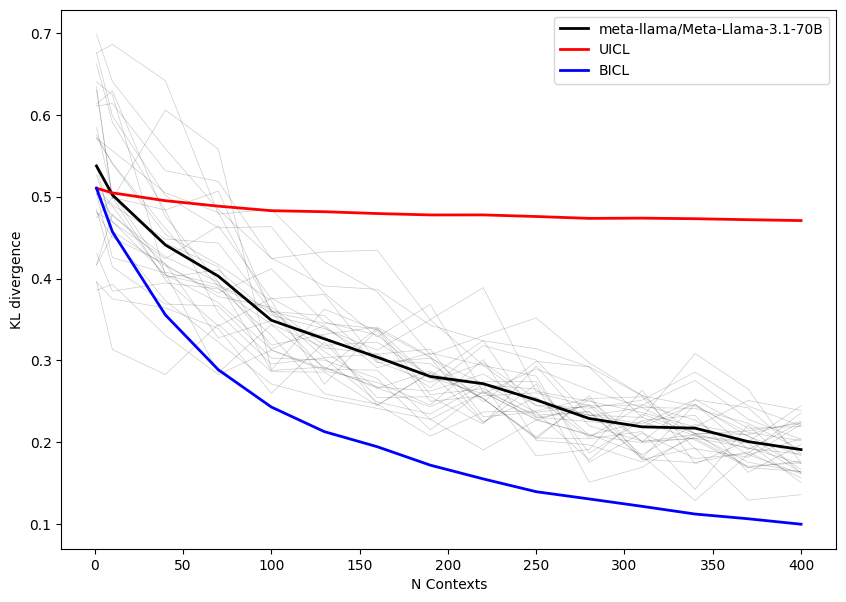

In [36]:
fig=plt.figure(figsize=(10,7))
plt.plot(n_contexts,kls.mean(0),c="k",lw=2,label=model_name)
for i in range(kls.shape[0]):
    plt.plot(n_contexts,kls[i],alpha=0.2,c="k",lw=0.5)
plt.plot(n_contexts,kls_UICL.mean(0),c="r",lw=2,label="UICL")
plt.plot(n_contexts,kls_BICL.mean(0),c="b",lw=2,label="BICL")
plt.xlabel("N Contexts")
plt.ylabel("KL divergence")
plt.legend()
data["fig"]=fig

In [37]:
torch.save(data,save_path)